Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from pathlib import Path

In [2]:
## Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("//content//gdrive//My Drive//Skin cancer ISIC The International Skin Imaging Collaboration//Train")
data_dir_test = pathlib.Path("//content//gdrive//My Drive//Skin cancer ISIC The International Skin Imaging Collaboration//Test")

In [4]:
# Counting the number of images in train and test folders
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Training dataset
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing the images to the 180*180.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation dataset
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing the images to the size 180*180.
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and storing them in a list. 
# Finding the class names in the class_names attribute on these datasets, correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

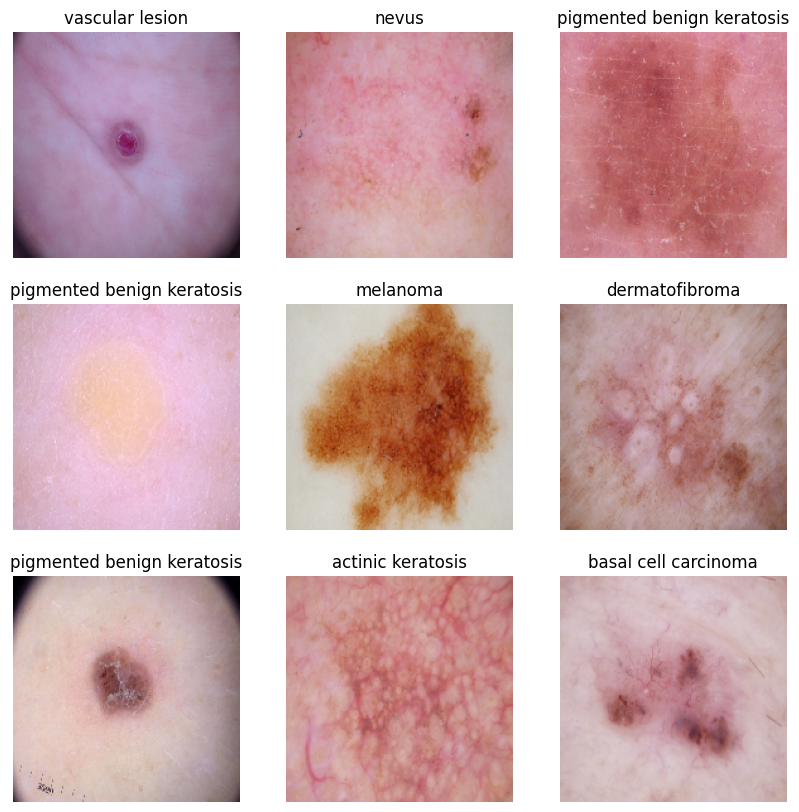

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [10]:
pd.set_option('display.max_rows', 100000)

# Checking the numerical form of the data which is in one batch
for item in train_ds.take(1):
    print(item)

(<tf.Tensor: shape=(32, 180, 180, 3), dtype=float32, numpy=
array([[[[ 68.666664,  50.625   ,  50.708336],
         [ 77.      ,  57.25    ,  57.875   ],
         [ 81.583336,  61.083336,  51.375   ],
         ...,
         [ 82.62503 ,  57.99994 ,  60.916626],
         [ 73.      ,  56.25    ,  55.375   ],
         [ 69.625015,  47.624985,  48.625046]],

        [[ 71.333336,  50.041664,  52.791668],
         [ 79.625   ,  60.375   ,  61.75    ],
         [ 87.458336,  64.708336,  67.125   ],
         ...,
         [ 84.37509 ,  58.791718,  62.625153],
         [ 74.125   ,  55.875   ,  55.375   ],
         [ 68.41675 ,  46.833374,  47.20836 ]],

        [[ 74.25    ,  56.041668,  56.625   ],
         [ 86.      ,  67.75    ,  70.5     ],
         [ 93.625   ,  72.125   ,  76.45833 ],
         ...,
         [ 87.91675 ,  64.79178 ,  59.291656],
         [ 80.5     ,  56.75    ,  58.875   ],
         [ 70.625015,  51.125015,  49.25    ]],

        ...,

        [[ 46.416668,  27.75    

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 - Normal model without data augmentation and dropout
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# Building a normal network without data augmentation, without dropouts and without batch normalisation
num_classes = len(class_names)

model_1 = Sequential([
  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
 
  layers.Dense(num_classes, activation = "softmax")
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
# Choosing Adam optimiser and sparse_categorical_crossentropy
model_1.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
# Train the model for 20 epochs
epochs = 20
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 289s 1s/step - loss: 2.0216 - accuracy: 0.2305 - val_loss: 1.8900 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7630 - accuracy: 0.3415 - val_loss: 1.6997 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5860 - accuracy: 0.4180 - val_loss: 1.4944 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4763 - accuracy: 0.4688 - val_loss: 1.4619 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4104 - accuracy: 0.4955 - val_loss: 1.3803 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3759 - accuracy: 0.5195 - val_loss: 1.4494 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2738 - accuracy: 0.5424 - val_loss: 1.3134 - val_accuracy: 0.5503
Epoch 8/20
56

### Visualizing training results

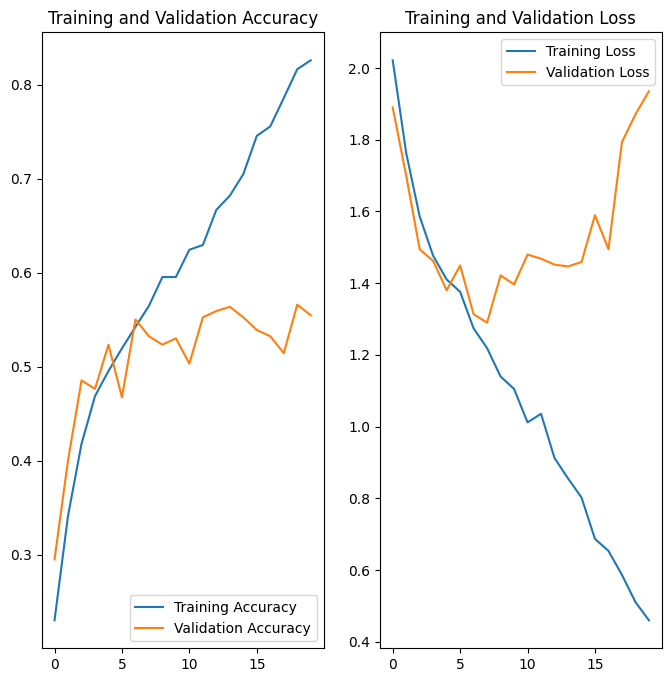

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from the model

1. The model is overfitting as the training and validation accuracy is far apart from the above figure.
2. Losses are also still high in validation but that for training is less.
3. The overfitting happens as the training data is too less(16 in 7 cases and 3 in 2 cases) which does not contain enough data samples to accurately represent all possible input data values.

## Model 2 - Model with data augmentation and dropout
#### Model with data augmentation using Keras. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [17]:
# Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

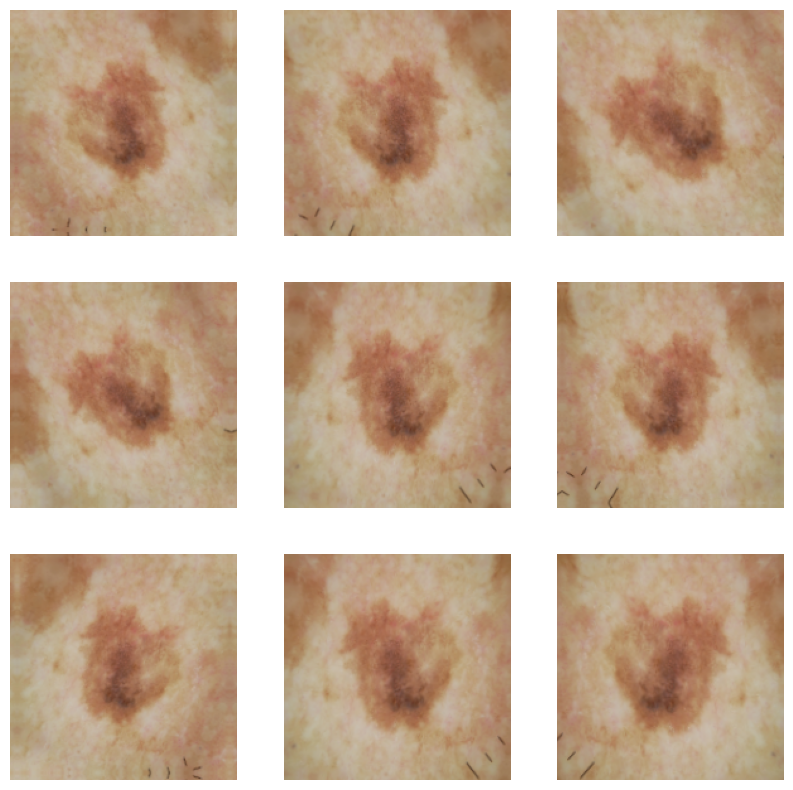

In [18]:
# visualizing how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [19]:
## Lets try building the model with augmented data. We are using a dropout of 0.2 in each layer and 0.3 in dense layer
model_2 = Sequential([
  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),


  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes, activation = "softmax")
])

### Compiling the model

In [20]:
model_2.compile(optimizer='adam', loss = "sparse_categorical_crossentropy" , metrics=['accuracy'])

### Training the model

In [21]:
## Training the model for 20 epochs
epochs = 20
history = model_2.fit( train_ds, validation_data=val_ds, epochs=epochs )

Epoch 1/20
56/56 [==============================] - 5s 36ms/step - loss: 2.0131 - accuracy: 0.2478 - val_loss: 1.8342 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.7789 - accuracy: 0.3510 - val_loss: 1.7604 - val_accuracy: 0.3602
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6513 - accuracy: 0.4046 - val_loss: 1.6309 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6845 - accuracy: 0.4090 - val_loss: 1.6210 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5666 - accuracy: 0.4381 - val_loss: 1.6032 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5152 - accuracy: 0.4654 - val_loss: 1.4963 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4908 - accuracy: 0.4788 - val_loss: 1.4695 - val_accuracy: 0.5190
Epoch 8/20
56

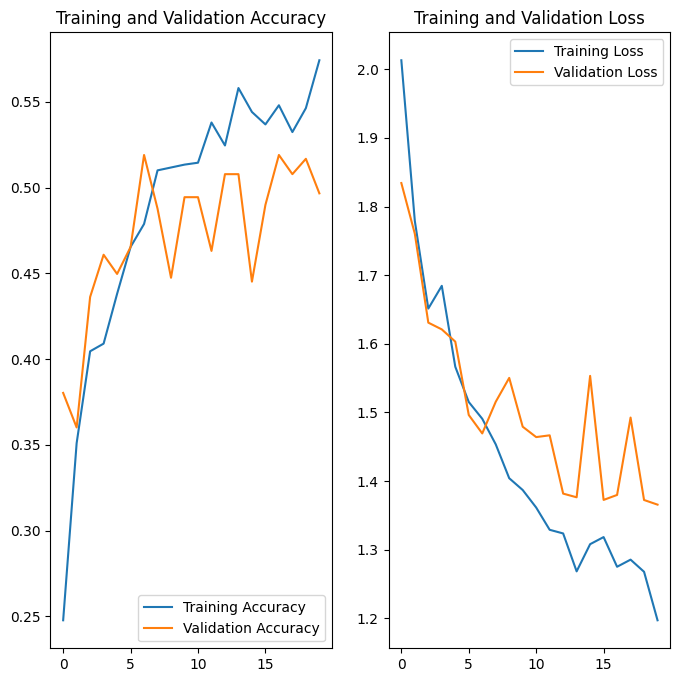

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inference for Keras based data augmentation
1. The model is underfit as the testing and validation accuracies are very low but close which is an indicator that the data augmentation and dropout has worked out. The model is generalised now but needs to be tuned to have better accuracies by using batch normalisation. 

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

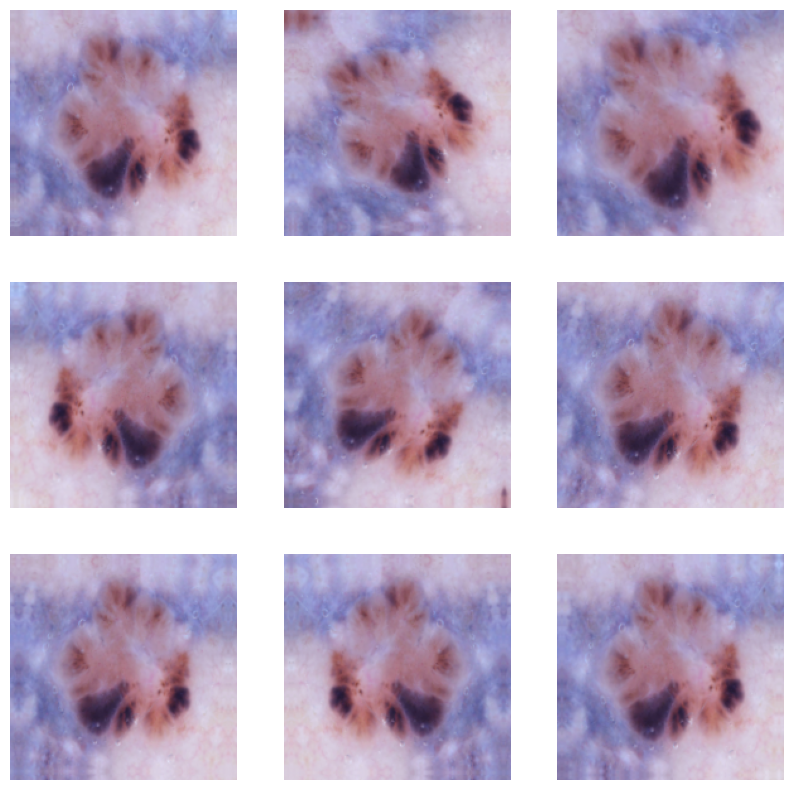

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [24]:
# Checking the class distribution
for i in class_names:
    directory = str(data_dir_train) + "//" + i +"//"
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


#### Observations 
#### - seborrheic keratosis has the least number of samples
#### - pigmented benign keratosis dominate the data in terms proportionate number of samples


## Model 3 - Data Augmented and Class balanced with dropouts and batch normalisation
#### Rectifying the class imbalance found in the sample
#### Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset = str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F912C44A040>: 100%|██████████| 500/500 [00:25<00:00, 19.97 Samples/s]


Initialised with 376 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F912C4024C0>: 100%|██████████| 500/500 [00:25<00:00, 19.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F912C4027F0>: 100%|██████████| 500/500 [00:22<00:00, 22.22 Samples/s]


Initialised with 438 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F91BC0B5430>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F912C485D60>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F912C3CC9D0>: 100%|██████████| 500/500 [00:22<00:00, 22.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F912C424910>: 100%|██████████| 500/500 [00:47<00:00, 10.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F912C3C5820>: 100%|██████████| 500/500 [00:20<00:00, 24.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to //content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F912C4E58B0>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
# Checking if all classes have added 500 more augmented images so that data augmented images are 4500 in number.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
# Building the dataframe to display the number of images in each folder
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [32]:
# Finding the number of images in each folder
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [34]:
data_dir_train = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### The number of images found above is augmented plus the original images

#### Creating a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model with normalization

In [36]:
import tensorflow as tf
from keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
## your code goes here
model_3 = Sequential([
  
#  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation = "softmax")
])



#### Compiling your model (Choose optimizer and loss function appropriately)

In [37]:
## Compiling the model with adam optimiser and cross entropy loss function
model_3.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics=['accuracy'])

#### Training the model

In [38]:
epochs = 30
history = model_3.fit( train_ds, validation_data = val_ds, epochs = epochs )

Epoch 1/30
169/169 [==============================] - 49s 243ms/step - loss: 2.7690 - accuracy: 0.3238 - val_loss: 4.1125 - val_accuracy: 0.0817
Epoch 2/30
169/169 [==============================] - 34s 197ms/step - loss: 1.4973 - accuracy: 0.4484 - val_loss: 2.9807 - val_accuracy: 0.1670
Epoch 3/30
169/169 [==============================] - 35s 201ms/step - loss: 1.4100 - accuracy: 0.4787 - val_loss: 2.6700 - val_accuracy: 0.3066
Epoch 4/30
169/169 [==============================] - 33s 193ms/step - loss: 1.2707 - accuracy: 0.5169 - val_loss: 1.6658 - val_accuracy: 0.4603
Epoch 5/30
169/169 [==============================] - 38s 220ms/step - loss: 1.1278 - accuracy: 0.5746 - val_loss: 1.5427 - val_accuracy: 0.5011
Epoch 6/30
169/169 [==============================] - 33s 192ms/step - loss: 1.0816 - accuracy: 0.5898 - val_loss: 2.6530 - val_accuracy: 0.3133
Epoch 7/30
169/169 [==============================] - 35s 202ms/step - loss: 0.9899 - accuracy: 0.6254 - val_loss: 1.3258 - val_ac

#### Visualizing the model results

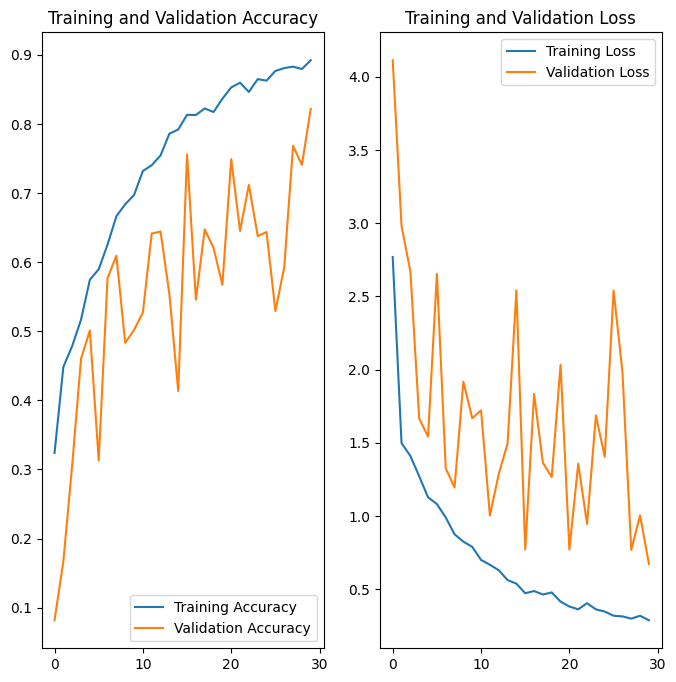

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inferences - There is no underfitting as the accuracies are high and also no overfitting as training and testing accuracies are close. Also the model needs to be fine tuned so that the losses are no such flucuating. This needs some colab time which allows for non pro users for limited time.

In [39]:
# Code for predicting a class

from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model_3.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )